In [ ]:
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = np.load("X_modified.npy").astype(np.float32)   # (N, 28, 28)
y = np.load("y_true.npy")                          # (N,)
print("X:", X.shape, "| y:", y.shape, "| min/max:", float(X.min()), float(X.max()))

unique_labels = np.unique(y)
K = len(unique_labels)
print("Detected classes:", unique_labels, "→ K =", K)


X: (1000, 28, 28) | y: (1000,) | min/max: 0.0 255.0
Detected classes: [1 4 7 9] → K = 4


In [ ]:
import numpy as np

class KMeansCustom:
    def __init__(self, k=3, max_iters=100, tol=1e-4, random_state=None):
        self.k = int(k)
        self.max_iters = int(max_iters)
        self.tol = float(tol)
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _rng(self):
        return np.random.default_rng(self.random_state)

    def _init_kmeanspp(self, X):
        """k-means++ initialization for stable starts."""
        n, d = X.shape
        rng = self._rng()
        centroids = np.empty((self.k, d), dtype=float)

        i0 = rng.integers(0, n)
        centroids[0] = X[i0]

        d2 = np.full(n, np.inf, dtype=float)
        for c in range(1, self.k):
            d2 = np.minimum(d2, np.sum((X - centroids[c-1])**2, axis=1))
            probs = d2 / (d2.sum() + 1e-12)
            idx = rng.choice(n, p=probs)
            centroids[c] = X[idx]
        return centroids

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        n, d = X.shape
        if self.k > n:
            raise ValueError("k cannot exceed number of samples")

        centroids = self._init_kmeanspp(X)

        for _ in range(self.max_iters):
            dists2 = ((X[:, None, :] - centroids[None, :, :])**2).sum(axis=2)
            labels = dists2.argmin(axis=1)

            new_centroids = centroids.copy()
            for j in range(self.k):
                mask = (labels == j)
                if np.any(mask):
                    new_centroids[j] = X[mask].mean(axis=0)
                else:
                    far_idx = np.argmax(np.min(dists2, axis=1))
                    new_centroids[j] = X[far_idx]

            shift = np.linalg.norm(new_centroids - centroids, ord=np.inf)
            centroids = new_centroids
            if shift <= self.tol:
                break

        self.centroids = centroids
        self.labels = labels
        return self


class PCAFromScratch:
    def __init__(self, n_components):
        self.n_components = int(n_components)
        self.mean_ = None
        self.components_ = None      # (k, d) rows = principal axes
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.singular_values_ = None
        self.fitted_ = False

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        n, d = X.shape
        if n < 2:
            raise ValueError("Need at least 2 samples for PCA")

        k = min(self.n_components, n, d)

        self.mean_ = X.mean(axis=0)
        Xc = X - self.mean_

        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)  # Xc = U S V^T
        self.components_ = Vt[:k, :]
        self.singular_values_ = S[:k]
        var_all = (S**2) / max(1, (n - 1))
        self.explained_variance_ = var_all[:k]
        tot = var_all.sum()
        self.explained_variance_ratio_ = (
            self.explained_variance_ / tot if tot > 0 else np.zeros_like(self.explained_variance_)
        )

        self.n_components = k
        self.fitted_ = True
        return self

    def transform(self, X):
        if not self.fitted_:
            raise RuntimeError("PCAFromScratch not fitted")
        X = np.asarray(X, dtype=float)
        Xc = X - self.mean_
        return Xc @ self.components_.T

    def fit_transform(self, X):
        return self.fit(X).transform(X)

    def checkPCA(self, X, atol=1e-6):
        if not self.fitted_:
            return False
        Z = self.transform(X)
        ok_shape = Z.shape[1] == self.n_components
        C = self.components_
        ok_ortho = np.allclose(C @ C.T, np.eye(self.n_components), atol=atol)
        ev = self.explained_variance_
        ok_monotonic = np.all(ev[:-1] >= ev[1:] - 1e-12)
        return bool(ok_shape and ok_ortho and ok_monotonic)


In [ ]:
import numpy as np
import cv2

def correct_orientation(image, thr=0.1):
    x = image.astype(np.float32)

    mn, mx = float(x.min()), float(x.max())
    if mx > mn:
        x = (x - mn) / (mx - mn)
    if x.mean() > 0.5:
        x = 1.0 - x

    coords = np.argwhere(x > thr)
    if coords.shape[0] < 10:
        return x  

    pca = PCAFromScratch(n_components=2).fit(coords)
    v_row, v_col = pca.components_[0, 0], pca.components_[0, 1]

    # angle of first PC vs x-axis; vertical is 90°
    angle_rad = np.arctan2(v_row, v_col)
    angle_deg = np.degrees(angle_rad)
    rotation_to_apply = angle_deg - 90.0

    center_rc = pca.mean_
    center_cr = (float(center_rc[1]), float(center_rc[0]))
    h, w = x.shape
    M = cv2.getRotationMatrix2D(center=center_cr, angle=rotation_to_apply, scale=1.0)
    rot = cv2.warpAffine(x, M, (w, h), flags=cv2.INTER_NEAREST, borderValue=0)

    top_mass = rot[:h//2].sum()
    bot_mass = rot[h//2:].sum()
    if bot_mass > top_mass:
        M180 = cv2.getRotationMatrix2D(center=(w/2.0, h/2.0), angle=180, scale=1.0)
        rot = cv2.warpAffine(rot, M180, (w, h), flags=cv2.INTER_NEAREST, borderValue=0)

    return rot.astype(np.float32)


In [4]:
X_rot = np.stack([correct_orientation(im, thr=0.1) for im in X], axis=0)
print("X_rot:", X_rot.shape, "| min/max:", float(X_rot.min()), float(X_rot.max()))


X_rot: (1000, 28, 28) | min/max: 0.0 1.0


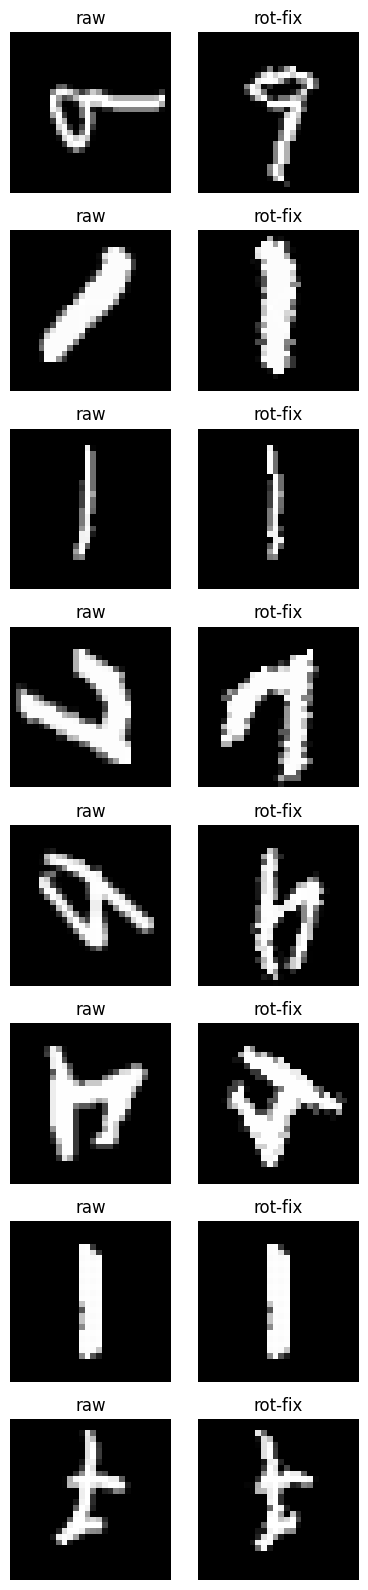

In [5]:
rng = np.random.default_rng(0)
idx = rng.choice(len(X), size=8, replace=False)

fig, axes = plt.subplots(len(idx), 2, figsize=(4, 2*len(idx)))
for i, k in enumerate(idx):
    axes[i,0].imshow(X[k], cmap='gray');     axes[i,0].set_title("raw");     axes[i,0].axis('off')
    axes[i,1].imshow(X_rot[k], cmap='gray'); axes[i,1].set_title("rot-fix"); axes[i,1].axis('off')
plt.tight_layout(); plt.show()


In [8]:
from sklearn.metrics import adjusted_rand_score  # metric only

def eval_pipeline_with_ari(X_in, y, k, pca_dim=40, seeds=(0,1,2,3,4)):
    Xv = X_in.reshape(len(X_in), -1).astype(np.float32)

    pca = PCAFromScratch(n_components=pca_dim).fit(Xv)
    Z = pca.transform(Xv)

    accs, aris = [], []
    for s in seeds:
        np.random.seed(s) 
        km = KMeansCustom(k=k, max_iters=100, tol=1e-4).fit(Z)
        labels = km.labels
        aris.append(adjusted_rand_score(y, labels))
    return float (np.mean(aris)), float(np.std(aris))

pca_dim = 100
print(f"Baseline (raw) → PCA{pca_dim} → KMeansCustom:")
b_ari_mu, b_ari_sd = eval_pipeline_with_ari(X, y, k=K, pca_dim=pca_dim)
print(f"  ARI      = {b_ari_mu:.4f} ± {b_ari_sd:.4f}")

print(f"\nTransformed (orientation-corrected) → PCA{pca_dim} → KMeansCustom:")
t_ari_mu, t_ari_sd = eval_pipeline_with_ari(X_rot, y, k=K, pca_dim=pca_dim)
print(f"  ARI      = {t_ari_mu:.4f} ± {t_ari_sd:.4f}")

print("\nImprovements:")
print(f"  ΔARI      = {t_ari_mu - b_ari_mu:+.4f}")


Baseline (raw) → PCA100 → KMeansCustom:
  ARI      = 0.1698 ± 0.0237

Transformed (orientation-corrected) → PCA100 → KMeansCustom:
  ARI      = 0.2735 ± 0.0335

Improvements:
  ΔARI      = +0.1037


Same digits align: before, one digit appeared in multiple angles , split into several distant groups. After rotation, all versions collapse into one tight cluster.

Better geometry in features: rotation noise is gone, so PCA emphasizes shape instead of angle.

Cleaner K-Means boundaries: with lower within-class spread and clearer separation between digits, K-Means assigns clusters more accurately (seen in higher ARI).

Still unsupervised: the whole fix uses only image geometry, so the comparison is fair.